In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

In [2]:
# 读取四张表的数据
# 读取了订单和产品id的关联，csv比较大
prior = pd.read_csv("./data/instacart/order_products__prior.csv")

In [3]:
# 产品id，与过道的对应
products = pd.read_csv("./data/instacart/products.csv")

In [4]:
# 订单id和用户id的对应，csv比较大
orders = pd.read_csv("./data/instacart/orders.csv")

In [6]:
# 超市的过道，过道放的产品的品类
aisles = pd.read_csv("./data/instacart/aisles.csv")

In [7]:
prior.head()  #订单id，产品id

order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        9327                  3          0
3         2       45918                  4          1
4         2       30035                  5          0

In [8]:
products.head() #产品id，产品名称，过道id

product_id                                       product_name  aisle_id  \
0           1                         Chocolate Sandwich Cookies        61   
1           2                                   All-Seasons Salt       104   
2           3               Robust Golden Unsweetened Oolong Tea        94   
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
4           5                          Green Chile Anytime Sauce         5   

   department_id  
0             19  
1             13  
2              7  
3              1  
4             13

In [9]:
orders.head() #订单id，用户id

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  
0                     NaN  
1                    15.0  
2                    21.0  
3                    29.0  
4                    28.0

In [27]:
aisles #过道id，对应过道里放了哪些产品类别

aisle_id                       aisle
0           1       prepared soups salads
1           2           specialty cheeses
2           3         energy granola bars
3           4               instant foods
4           5  marinades meat preparation
..        ...                         ...
129       130    hot cereal pancake mixes
130       131                   dry pasta
131       132                      beauty
132       133  muscles joints pain relief
133       134  specialty wines champagnes

[134 rows x 2 columns]

In [12]:
# 合并四张表到一张表  （用户-物品类别）
#订单表和产品表关联
#用户买了哪些订单，订单里面有哪些产品，产品对应的过道，过道对应的产品类别
_mg = pd.merge(prior, products, on=['product_id', 'product_id'])
_mg = pd.merge(_mg, orders, on=['order_id', 'order_id'])
mt = pd.merge(_mg, aisles, on=['aisle_id', 'aisle_id'])

In [13]:
mt.head(10)

order_id  product_id  add_to_cart_order  reordered        product_name  \
0         2       33120                  1          1  Organic Egg Whites   
1        26       33120                  5          0  Organic Egg Whites   
2       120       33120                 13          0  Organic Egg Whites   
3       327       33120                  5          1  Organic Egg Whites   
4       390       33120                 28          1  Organic Egg Whites   
5       537       33120                  2          1  Organic Egg Whites   
6       582       33120                  7          1  Organic Egg Whites   
7       608       33120                  5          1  Organic Egg Whites   
8       623       33120                  1          1  Organic Egg Whites   
9       689       33120                  4          1  Organic Egg Whites   

   aisle_id  department_id  user_id eval_set  order_number  order_dow  \
0        86             16   202279    prior             3          5   
1        86             16   153404    prior             2          0   
2        86             16    23750    prior            11          6   
3        86             16    58707    prior            21          6   
4        86             16   166654    prior            48          0   
5        86             16   180135    prior            15          2   
6        86             16   193223    prior             6          2   
7        86             16    91030    prior            11          3   
8        86             16    37804    prior            63          3   
9        86             16   108932    prior            16          1   

   order_hour_of_day  days_since_prior_order aisle  
0                  9                     8.0  eggs  
1                 16                     7.0  eggs  
2                  8                    10.0  eggs  
3                  9                     8.0  eggs  
4                 12                     9.0  eggs  
5                  8                     3.0  eggs  
6                 19                    10.0  eggs  
7                 21                    12.0  eggs  
8                 12                     3.0  eggs  
9                 13                     3.0  eggs

In [15]:
mt.shape

(32434489, 14)

In [16]:
mt.isnull().sum()/len(mt)  #数据缺失率，没有缺失值

order_id                  0.00000
product_id                0.00000
add_to_cart_order         0.00000
reordered                 0.00000
product_name              0.00000
aisle_id                  0.00000
department_id             0.00000
user_id                   0.00000
eval_set                  0.00000
order_number              0.00000
order_dow                 0.00000
order_hour_of_day         0.00000
days_since_prior_order    0.06407
aisle                     0.00000
dtype: float64

In [17]:
# 交叉表（特殊的分组工具），如果在这一步内存不够了，重启一下jupyter，还是不行，筛选一部分用户的数据，进行聚类
# 每个用户去过哪几个过道
cross = pd.crosstab(mt['user_id'], mt['aisle'])

In [18]:
cross.head(10)

aisle    air fresheners candles  asian foods  baby accessories  \
user_id                                                          
1                             0            0                 0   
2                             0            3                 0   
3                             0            0                 0   
4                             0            0                 0   
5                             0            2                 0   
6                             0            0                 0   
7                             0            0                 0   
8                             0            1                 0   
9                             0            0                 0   
10                            0            1                 0   

aisle    baby bath body care  baby food formula  bakery desserts  \
user_id                                                            
1                          0                  0                0   
2                          0                  0                0   
3                          0                  0                0   
4                          0                  0                0   
5                          0                  0                0   
6                          0                  0                0   
7                          0                  0                0   
8                          0                  0                0   
9                          0                  6                0   
10                         0                  0                0   

aisle    baking ingredients  baking supplies decor  beauty  beers coolers  \
user_id                                                                     
1                         0                      0       0              0   
2                         2                      0       0              0   
3                         0                      0       0              0   
4                         0                      0       0              0   
5                         0                      0       0              0   
6                         0                      0       0              0   
7                         2                      0       0              0   
8                         1                      0       0              0   
9                         2                      0       0              0   
10                        0                      0       0              0   

aisle    ...  spreads  tea  tofu meat alternatives  tortillas flat bread  \
user_id  ...                                                               
1        ...        1    0                       0                     0   
2        ...        3    1                       1                     0   
3        ...        4    1                       0                     0   
4        ...        0    0                       0                     1   
5        ...        0    0                       0                     0   
6        ...        0    0                       0                     0   
7        ...        0    0                       0                     0   
8        ...        0    0                       0                     0   
9        ...        0    0                       0                     0   
10       ...        0    0                       0                     0   

aisle    trail mix snack mix  trash bags liners  vitamins supplements  \
user_id                                                                 
1                          0                  0                     0   
2                          0                  0                     0   
3                          0                  0                     0   
4                          0                  0                     0   
5                          0                  0                     0   
6                          0             

In [21]:
print(mt['aisle_id'].nunique()) # 134个过道，每个过道都放自己的产品类别
print(mt['aisle'].nunique())

134
134


In [28]:
#针对20万用户，有134个特征
cross.shape

(206209, 134)

In [30]:
# 进行主成分分析，保留90%的成分，实际特征数目减少了134--》27
pca = PCA(n_components=0.9)


In [31]:
data = pca.fit_transform(cross)
data.shape

(206209, 27)

In [32]:
type(data)

numpy.ndarray

In [33]:
# 挑选前500个用户的数据进行聚类
x = data[:500]
x.shape

(500, 27)

In [35]:
print(x)

[[-24.21565874   2.4294272   -2.46636975 ...   0.68680034   1.69439402
   -2.34323022]
 [  6.46320806  36.75111647   8.38255336 ...   4.12121252   2.4468974
   -4.28348478]
 [ -7.99030162   2.40438257 -11.03006405 ...   1.77534453  -0.44419403
    0.78666557]
 ...
 [-11.92661183  -6.28156437   6.49043833 ...  -0.93499096  -0.1409791
    0.04370174]
 [-18.05675245  -0.42589035  -3.92660866 ...  -1.02048351  -0.95283767
    0.90135767]
 [-24.62244434  -0.5635177   -0.90551124 ...   0.86904501  -2.15569229
   -0.40915483]]


In [36]:
x.max()

407.18563418250557

In [37]:
x.min()

-242.3484794930586

In [59]:
# 假设用户一共分为四个类别
#n_clusters是分为几个类别，是主要的超参
km = KMeans(n_clusters=4)

In [60]:
km.fit(x)  #开始训练

D:\3.8\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=4)

In [61]:
#开始预测
predict = km.predict(x)

In [48]:
print(type(predict))
print(predict.shape)

<class 'numpy.ndarray'>
(500,)


### 以之前的跨国礼品销售RFM划分用户等级为例，我们采用聚类算法，然后手动挑选出这4类用户进行分析

In [62]:
print(predict)  #预测得到的是每一个样本的类别

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 2
 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 2 0 0 0
 2 0 0 0 0 0 0 0 0 0 0 2 0 0 2 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 2 0 0 0 2 0 0
 0 0 0 3 2 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 2 0 2 0 0 0 0 3 1 0 0 0 2 0 0 0 0 0 0 0 0
 3 0 0 0 2 0 0 0 0 2 2 2 0 2 0 0 0 0 0 0 2 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2 0 0 0 0 0 0 0 1 2 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 1 0 0 0 0 0 0 0 2 0 3 0 0 0 2 0 0 0 0 0 0
 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 2 0 0 0 0 2 0 0 0 0
 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 2 0 0 0 2 0 2 0 0 0 0 0 0 0 3 0 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2
 0 0 0 0 2 2 0 0 0 0 0 0 

In [53]:
import numpy as np
np.unique(predict)

array([0, 1, 2, 3])

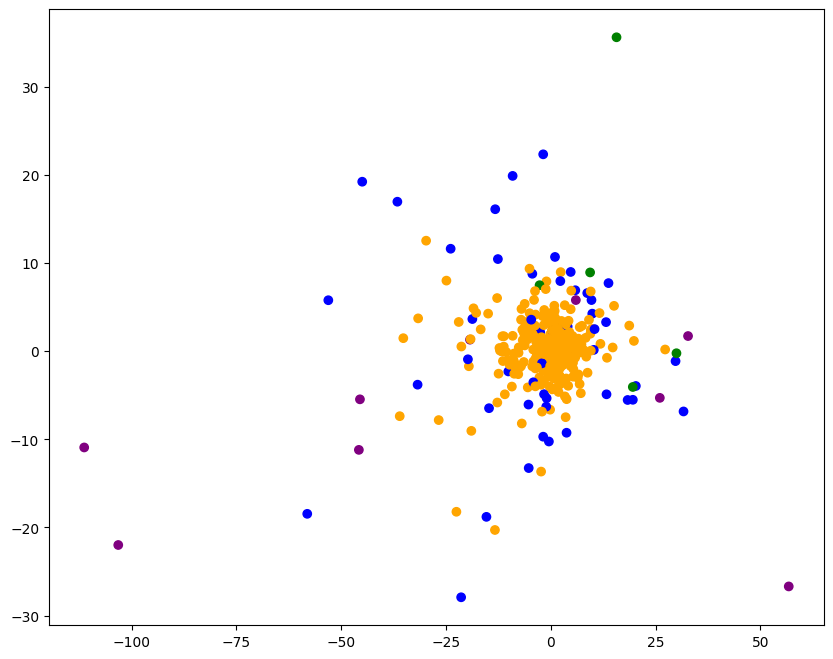

In [63]:
# 显示聚类的结果
plt.figure(figsize=(10, 8))
# 建立四个颜色的列表
colored = ['orange', 'green', 'blue', 'purple']
colr = [colored[i] for i in predict]
#去选择任意两个特征来看聚类的图，可以自行调整,第2个，第20个特征
plt.scatter(x[:, 3], x[:, 21], color=colr)


### 评判聚类效果，轮廓系数

In [64]:
# 评判聚类效果，轮廓系数，聚类效果很难超过0.7，可以通过这个得分去调整上面KMeans的n_clusters
silhouette_score(x, predict)

0.6223046503285691

### 实际上要分成几类，还得看需求

In [71]:
# 改为2时的结果
km = KMeans(n_clusters=2)
km.fit(x)  #开始训练
predict = km.predict(x)
print(silhouette_score(x, predict))
print("-"*50)
print(predict)

0.6779999767609063
--------------------------------------------------
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 1 0 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0

D:\3.8\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [72]:
# 通过分类后数据，去看原始样本的特点
cross.iloc[0]

aisle
air fresheners candles           0
asian foods                      0
baby accessories                 0
baby bath body care              0
baby food formula                0
                                ..
trash bags liners                0
vitamins supplements             0
water seltzer sparkling water    0
white wines                      0
yogurt                           1
Name: 1, Length: 134, dtype: int64

In [73]:
print(predict[26])
cross.iloc[26]  # 26号用户是第二类用户，看一下他去过哪些过道

1


aisle
air fresheners candles             0
asian foods                        4
baby accessories                   0
baby bath body care                0
baby food formula                  0
                                ... 
trash bags liners                  0
vitamins supplements               0
water seltzer sparkling water     92
white wines                        0
yogurt                           150
Name: 27, Length: 134, dtype: int64